In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
vix_df = pd.read_csv('data/VIX_SP.csv', index_col=0)
vix_df.index = pd.to_datetime(vix_df.index)
vix_df = vix_df.dropna()

In [3]:
GARCH = arch_model(
    vix_df['ret'] * 100,
    mean = 'ARX',
    vol='GARCH',
    p=1, q=1,
).fit()

print(GARCH.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 71997063730777.08
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1985895981.8507242
Iteration:      3,   Func. Count:     22,   Neg. LLF: 6168.937624349892
Iteration:      4,   Func. Count:     28,   Neg. LLF: 5033.8904133743235
Iteration:      5,   Func. Count:     36,   Neg. LLF: 5560.043232292807
Iteration:      6,   Func. Count:     42,   Neg. LLF: 4465.090486000899
Iteration:      7,   Func. Count:     47,   Neg. LLF: 4465.087752453172
Iteration:      8,   Func. Count:     52,   Neg. LLF: 4465.0875898703525
Iteration:      9,   Func. Count:     56,   Neg. LLF: 4465.0875898697195
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4465.0875898703525
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
                           AR - GARCH Model Results                           
Dep. Variable:                    ret   R-squared:           

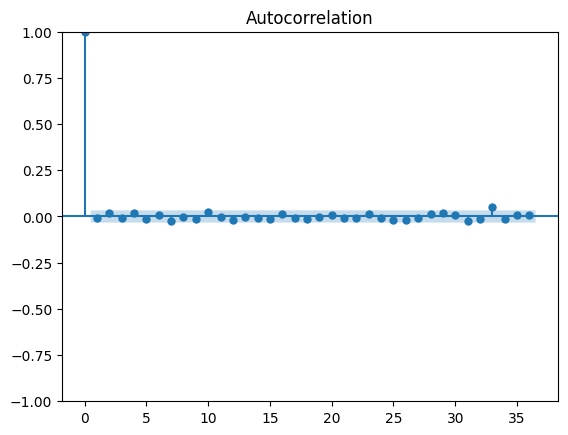

In [4]:
sqr = GARCH.std_resid ** 2
garch_sqr_acf = plot_acf(sqr)

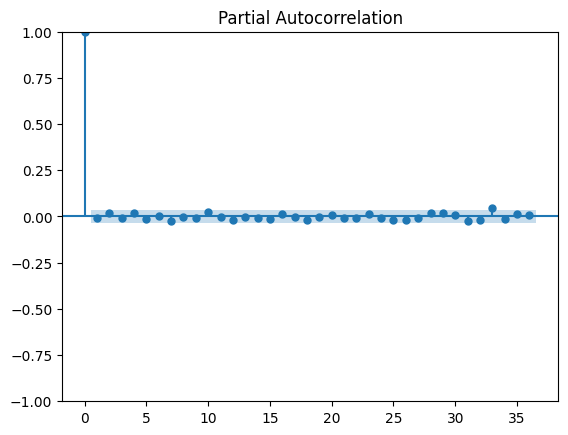

In [5]:
garch_sqr_pacf = plot_pacf(sqr)

In [6]:
vix_df['Monday'] = (vix_df.index.dayofweek == 0).astype(int)
vix_df['Friday'] = (vix_df.index.dayofweek == 4).astype(int)

<!-- OLD VERSION NOTE (commented out):
Unfortunately this won't work as the dummy variable is taken from the LHS
-->

In [7]:
GARCH_dummy = arch_model(
    vix_df['ret'] * 100,
    x = vix_df['Monday'],
    mean = 'ARX',
    vol='GARCH',
    p=1, q=1,
).fit(disp='off')

In [8]:
ret = vix_df['ret'] * 100
ret_demeaned = ret - ret.mean()
monday = vix_df['Monday'].values
friday = vix_df['Friday'].values

Function to run GARCH(1,1) for Monday

In [9]:
def garch_mon_loglik(params, y, mon):
    omega, alpha, beta, gamma_mon = params
    y = np.asarray(y)
    mon = np.asarray(mon)
    T = y.shape[0]
    eps = y
    h = np.empty(T)
    h[0] = np.var(eps)
    for t in range(1, T):
        h[t] = (omega + alpha * eps[t - 1] ** 2 + beta * h[t - 1] + gamma_mon * mon[t])
    h = np.clip(h, 1e-8, np.inf)
    ll = -0.5 * (np.log(2 * np.pi) + np.log(h) + eps**2 / h)
    return ll.sum()


def fit_garch_mon(y, mon, start_params=None):
    y = np.asarray(y)
    mon = np.asarray(mon)

    if start_params is None:
        start_params = np.array([0.1, 0.05, 0.9, 0.0])

    def neg_loglik(p):
        return -garch_mon_loglik(p, y, mon)

    opt_res = minimize(neg_loglik, start_params, method="L-BFGS-B")
    return opt_res.x, opt_res

In [10]:
start_params_mon = np.array([0.1, 0.05, 0.9, 0.0])
params_mon, opt_res = fit_garch_mon(ret_demeaned.values, monday, start_params_mon)

omega_m, alpha_m, beta_m, gamma_mon_m = params_mon

In [39]:
print("Monday model coefficient estimates:")
print(f"gamma_mon: {gamma_mon_m:.6f}")

Monday model coefficient estimates:
gamma_mon: -0.101411


Function to run GARCH(1,1) for Monday and Friday

In [12]:
def garch_monfri_loglik(params, y, mon, fri):
    omega, alpha, beta, gamma_mon, gamma_fri = params
    y = np.asarray(y)
    mon = np.asarray(mon)
    fri = np.asarray(fri)
    T = y.shape[0]

    eps = y
    h = np.empty(T)
    h[0] = np.var(eps)
    for t in range(1, T):
        h[t] = (omega + alpha * eps[t - 1] ** 2 + beta * h[t - 1] + gamma_mon * mon[t] + gamma_fri * fri[t])
    h = np.clip(h, 1e-8, np.inf)

    ll = -0.5 * (np.log(2 * np.pi) + np.log(h) + eps**2 / h)
    return ll.sum()


def fit_garch_monfri(y, mon, fri, start_params=None):
    y = np.asarray(y)
    mon = np.asarray(mon)
    fri = np.asarray(fri)

    if start_params is None:
        start_params = np.array([0.1, 0.05, 0.9, 0.0, 0.0])

    def neg_loglik(p):
        return -garch_monfri_loglik(p, y, mon, fri)

    opt_res = minimize(neg_loglik, start_params, method="L-BFGS-B")
    return opt_res.x, opt_res

In [13]:
start_params_monfri = np.array([0.1, 0.05, 0.9, 0.0, 0.0])
params_monfri, opt_res_mf = fit_garch_monfri(ret_demeaned.values, monday, friday, start_params_monfri)

omega_mf, alpha_mf, beta_mf, gamma_mon_mf, gamma_fri_mf = params_monfri

In [40]:
print("Monday+Friday model coefficient estimates:")
print(f"gamma_mon: {gamma_mon_mf:.6f}")
print(f"gamma_fri: {gamma_fri_mf:.6f}")

Monday+Friday model coefficient estimates:
gamma_mon: -0.105825
gamma_fri: -0.042820


In [15]:
vix_annual_vol = vix_df['VIX'] / 100
vix_daily_var  = vix_annual_vol**2 / 252
vix_var_lag1   = vix_daily_var.shift(1)

df_vix = vix_df.copy()
df_vix['vix_var_lag1'] = vix_var_lag1
df_vix = df_vix.dropna(subset=['vix_var_lag1'])

vix_l  = df_vix['vix_var_lag1'].values

In [16]:
y = df_vix['ret'] * 100
y = y - y.mean()                     
monday = df_vix['Monday'].values
friday = df_vix['Friday'].values

In [17]:
def garch_monfri_vix_loglik(params, y, mon, fri, vix_l):
    omega, alpha, beta, gamma_mon, gamma_fri, delta_vix = params
    y = np.asarray(y)
    mon = np.asarray(mon)
    fri = np.asarray(fri)
    vix_l = np.asarray(vix_l)
    T = y.shape[0]
    eps = y
    h = np.empty(T)
    h[0] = np.var(eps)
    for t in range(1, T):
        h[t] = (omega + alpha * eps[t - 1]**2 + beta  * h[t - 1] + gamma_mon * mon[t] + gamma_fri * fri[t] + delta_vix * vix_l[t])
    h = np.clip(h, 1e-8, np.inf)
    ll = -0.5 * (np.log(2 * np.pi) + np.log(h) + eps**2 / h)
    return ll.sum()

def fit_garch_monfri_vix(y, mon, fri, vix_l, start_params=None):
    y     = np.asarray(y)
    mon   = np.asarray(mon)
    fri   = np.asarray(fri)
    vix_l = np.asarray(vix_l)
    if start_params is None:
        start_params = np.array([0.1, 0.05, 0.9, 0.0, 0.0, 0.0])
    def neg_loglik(p):
        return -garch_monfri_vix_loglik(p, y, mon, fri, vix_l)
    opt_res = minimize(neg_loglik, start_params, method='L-BFGS-B')
    return opt_res.x, opt_res

In [18]:
start_params_vix = np.array([0.1, 0.05, 0.9, 0.0, 0.0, 0.0])
params_mfv, opt_res_mfv = fit_garch_monfri_vix(y.values, monday, friday, vix_l, start_params_vix)

omega_v, alpha_v, beta_v, gamma_mon_v, gamma_fri_v, delta_vix_v = params_mfv

In [41]:
print("Monday+Friday+VIX model coefficient estimates:")
print(f"gamma_mon: {gamma_mon_v:.6f}")
print(f"gamma_fri: {gamma_fri_v:.6f}")
print(f"delta_vix: {delta_vix_v:.6f}")

Monday+Friday+VIX model coefficient estimates:
gamma_mon: -0.106180
gamma_fri: -0.043454
delta_vix: 0.000717


In [20]:
print("Estimated parameters (Mon/Fri + lagged VIX variance model):")
print("omega:", omega_v)
print("alpha:", alpha_v)
print("beta:", beta_v)
print("gamma_mon (Monday variance effect):", gamma_mon_v)
print("gamma_fri (Friday variance effect):", gamma_fri_v)
print("delta_vix (lagged VIX variance effect):", delta_vix_v)

Estimated parameters (Mon/Fri + lagged VIX variance model):
omega: 0.06794932666081649
alpha: 0.1738965339208141
beta: 0.7910381558123754
gamma_mon (Monday variance effect): -0.10618029098854555
gamma_fri (Friday variance effect): -0.043454315747841595
delta_vix (lagged VIX variance effect): 0.0007171255837357331


In [21]:
def compute_aic(loglik: float, k: int) -> float:
    """Akaike Information Criterion.

    Parameters
    ----------
    loglik : float
        Maximized log-likelihood of the model.
    k : int
        Number of estimated parameters.
    """
    return 2 * k - 2 * loglik


def compute_bic(loglik: float, k: int, n: int) -> float:
    """Bayesian Information Criterion.

    Parameters
    ----------
    loglik : float
        Maximized log-likelihood of the model.
    k : int
        Number of estimated parameters.
    n : int
        Sample size used to estimate the model.
    """
    return np.log(n) * k - 2 * loglik

In [22]:
# Example usage with ARCHModelResult objects (like GARCH, GARCH_dummy):
# loglik = GARCH.loglikelihood
# k = GARCH.num_params
# n = GARCH.nobs
# aic_garch = compute_aic(loglik, k)
# bic_garch = compute_bic(loglik, k, n)

In [23]:
# 1) GARCH(1,1) with Monday dummy
garch_mon_loglik_value = -opt_res.fun
k_mon = len(params_mon)
n_mon = len(ret_demeaned)

aic_mon = compute_aic(garch_mon_loglik_value, k_mon)
bic_mon = compute_bic(garch_mon_loglik_value, k_mon, n_mon)

print("GARCH Mon: loglik =", garch_mon_loglik_value)
print("GARCH Mon: AIC =", aic_mon)
print("GARCH Mon: BIC =", bic_mon)

GARCH Mon: loglik = -4465.2226830639
GARCH Mon: AIC = 8938.4453661278
GARCH Mon: BIC = 8963.11136740442


In [24]:
# 2) GARCH(1,1) with Monday and Friday dummies
garch_monfri_loglik_value = -opt_res_mf.fun
k_monfri = len(params_monfri)
n_monfri = len(ret_demeaned)

aic_monfri = compute_aic(garch_monfri_loglik_value, k_monfri)
bic_monfri = compute_bic(garch_monfri_loglik_value, k_monfri, n_monfri)

print("GARCH Mon/Fri: loglik =", garch_monfri_loglik_value)
print("GARCH Mon/Fri: AIC =", aic_monfri)
print("GARCH Mon/Fri: BIC =", bic_monfri)

GARCH Mon/Fri: loglik = -4464.457622809714
GARCH Mon/Fri: AIC = 8938.915245619428
GARCH Mon/Fri: BIC = 8969.747747215202


In [25]:
# 3) GARCH(1,1) with Monday, Friday dummies and lagged VIX variance
garch_monfri_vix_loglik_value = -opt_res_mfv.fun
k_mfv = len(params_mfv)
n_mfv = len(y)

aic_mfv = compute_aic(garch_monfri_vix_loglik_value, k_mfv)
bic_mfv = compute_bic(garch_monfri_vix_loglik_value, k_mfv, n_mfv)

print("GARCH Mon/Fri + VIX: loglik =", garch_monfri_vix_loglik_value)
print("GARCH Mon/Fri + VIX: AIC =", aic_mfv)
print("GARCH Mon/Fri + VIX: BIC =", bic_mfv)

GARCH Mon/Fri + VIX: loglik = -4463.7609688235025
GARCH Mon/Fri + VIX: AIC = 8939.521937647005
GARCH Mon/Fri + VIX: BIC = 8976.519235258558


In [42]:
print(GARCH.aic)
print(GARCH.bic)

8938.175179740705
8962.841181017326


In [27]:
from scipy.stats import chi2

# ---------- Robust significance via LR tests ----------
def lr_pvalue(ll_unrestricted: float, ll_restricted: float, df: int = 1) -> tuple[float, float]:
    lr_stat = 2.0 * (ll_unrestricted - ll_restricted)
    p_val = 1.0 - chi2.cdf(lr_stat, df)
    return lr_stat, p_val

# Monday effect: compare Mon model vs base GARCH (gamma_mon = 0)
def garch_base_loglik(params, y):
    omega, alpha, beta = params
    y = np.asarray(y)
    T = y.shape[0]
    eps = y
    h = np.empty(T)
    h[0] = np.var(eps)
    for t in range(1, T):
        h[t] = omega + alpha * eps[t - 1] ** 2 + beta * h[t - 1]
    h = np.clip(h, 1e-8, np.inf)
    ll = -0.5 * (np.log(2 * np.pi) + np.log(h) + eps**2 / h)
    return ll.sum()


def fit_garch_base(y, start_params=None):
    y = np.asarray(y)
    if start_params is None:
        start_params = np.array([0.1, 0.05, 0.9])

    def neg_loglik(p):
        return -garch_base_loglik(p, y)

    res = minimize(neg_loglik, start_params, method="L-BFGS-B")
    return res.x, res

# Sample for Monday/Friday models
y_mf = ret_demeaned.values
mon_mf = vix_df["Monday"].values
fri_mf = vix_df["Friday"].values

_, opt_res_base = fit_garch_base(y_mf)
ll_base = -opt_res_base.fun
ll_mon = -opt_res.fun
ll_monfri = -opt_res_mf.fun

lr_mon, p_mon_lr = lr_pvalue(ll_mon, ll_base, df=1)
lr_fri, p_fri_lr = lr_pvalue(ll_monfri, ll_mon, df=1)

# VIX effect: compare MF+VIX vs MF on the SAME aligned sample
y_aligned = y.values
mon_aligned = monday
fri_aligned = friday

_, opt_res_mf_aligned = fit_garch_monfri(y_aligned, mon_aligned, fri_aligned)
ll_mf_aligned = -opt_res_mf_aligned.fun
ll_mfv = -opt_res_mfv.fun

lr_vix, p_vix_lr = lr_pvalue(ll_mfv, ll_mf_aligned, df=1)

print("LR-test p-values (robust to quasi-Newton Hessian issues):")
print(f"Monday effect p-value: {p_mon_lr:.6f}")
print(f"Friday effect p-value: {p_fri_lr:.6f}")
print(f"Lagged VIX effect p-value: {p_vix_lr:.6f}")

# ---------- AIC/BIC check on comparable model sets ----------
def add_ic_columns(df):
    out = df.copy()
    out["AIC"] = [compute_aic(ll, k) for ll, k in zip(out["LogLik"], out["k"])]
    out["BIC"] = [compute_bic(ll, k, n) for ll, k, n in zip(out["LogLik"], out["k"], out["n"])]
    out["AIC_per_obs"] = out["AIC"] / out["n"]
    out["BIC_per_obs"] = out["BIC"] / out["n"]
    return out

ic_main = pd.DataFrame(
    {
        "Model": ["Base GARCH", "Mon", "Mon+Fri"],
        "LogLik": [ll_base, ll_mon, ll_monfri],
        "k": [3, len(params_mon), len(params_monfri)],
        "n": [len(y_mf), len(y_mf), len(y_mf)],
    }
)
ic_main = add_ic_columns(ic_main)

ic_vix = pd.DataFrame(
    {
        "Model": ["Mon+Fri (aligned)", "Mon+Fri+VIX"],
        "LogLik": [ll_mf_aligned, ll_mfv],
        "k": [len(params_monfri), len(params_mfv)],
        "n": [len(y_aligned), len(y_aligned)],
    }
)
ic_vix = add_ic_columns(ic_vix)

print("\nAIC/BIC (same-sample comparisons only):")
print(ic_main[["Model", "AIC", "BIC", "AIC_per_obs", "BIC_per_obs"]].to_string(index=False))
print()
print(ic_vix[["Model", "AIC", "BIC", "AIC_per_obs", "BIC_per_obs"]].to_string(index=False))
print("\nNote: some references report normalized IC (per observation), which can be much smaller than total AIC/BIC.")

LR-test p-values (robust to quasi-Newton Hessian issues):
Monday effect p-value: 0.002375
Friday effect p-value: 0.216094
Lagged VIX effect p-value: 0.987100

AIC/BIC (same-sample comparisons only):
     Model         AIC         BIC  AIC_per_obs  BIC_per_obs
Base GARCH 8945.680197 8964.179698     2.540665     2.545919
       Mon 8938.445366 8963.111367     2.538610     2.545615
   Mon+Fri 8938.915246 8969.747747     2.538743     2.547500

            Model         AIC         BIC  AIC_per_obs  BIC_per_obs
Mon+Fri (aligned) 8937.522199 8968.353280     2.539069     2.547828
      Mon+Fri+VIX 8939.521938 8976.519235     2.539637     2.550148

Note: some references report normalized IC (per observation), which can be much smaller than total AIC/BIC.


In [28]:
nasdaq_df = pd.read_excel('data/nasdaq-1.xlsx', index_col=0)

In [29]:
nasdaq_df['SecondsPast'] = nasdaq_df.index/1000

Estimate a component for GARCH model this day

In [30]:
day = 1
df_day = nasdaq_df[nasdaq_df["DAY"] == day].copy()
df_day["r2"] = df_day["NQ_RET"] ** 2
df_day = df_day.dropna(subset=["r2"])
t = (df_day["SecondsPast"] - df_day["SecondsPast"].min()) / 3600

In [31]:
t

NQTIMESINCEMIDNIGHT
33899996    0.000000
34199999    0.083334
34499888    0.166637
34799976    0.249994
35099970    0.333326
              ...   
51899972    4.999993
52199999    5.083334
52499986    5.166664
52799894    5.249972
53099895    5.333305
Name: SecondsPast, Length: 65, dtype: float64

In [32]:
X = np.column_stack([t, t ** 2, t ** 3])
X = sm.add_constant(X)
phi_model = sm.OLS(df_day["r2"], X).fit()

In [46]:
print(phi_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     r2   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9296
Date:                Thu, 19 Feb 2026   Prob (F-statistic):              0.432
Time:                        16:55:36   Log-Likelihood:                 773.41
No. Observations:                  65   AIC:                            -1539.
Df Residuals:                      61   BIC:                            -1530.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.989e-06   7.96e-07      2.498      0.0

In [33]:
df_day["phi_t"] = phi_model.fittedvalues
df_day["phi_t"] = np.maximum(df_day["phi_t"], 1e-8)

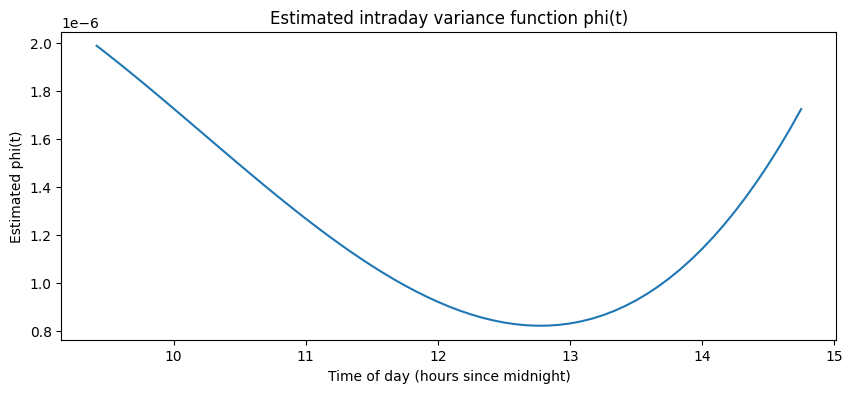

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df_day["SecondsPast"] / 3600.0, df_day["phi_t"])
ax.set_xlabel("Time of day (hours since midnight)")
ax.set_ylabel("Estimated phi(t)")
ax.set_title("Estimated intraday variance function phi(t)")
plt.show()

In [35]:
tilde_r = df_day["NQ_RET"] / np.sqrt(df_day["phi_t"])
garch_comp = arch_model(tilde_r, mean="Zero", vol="GARCH", p=1, q=1).fit(disp="off")

In [44]:
print(garch_comp.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.015
Vol Model:                      GARCH   Log-Likelihood:               -92.3377
Distribution:                  Normal   AIC:                           190.675
Method:            Maximum Likelihood   BIC:                           197.199
                                        No. Observations:                   65
Date:                Thu, Feb 19 2026   Df Residuals:                       65
Time:                        16:28:24   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.3307      0.702      0.471      0.637 

In [36]:
df_day["h_t"] = garch_comp.conditional_volatility ** 2
print("Mean of h_t (should be about 1):", df_day["h_t"].mean())

Mean of h_t (should be about 1): 1.0105861109203702


In [37]:
sigma_seasonal = np.sqrt(df_day["phi_t"])
sigma_total = np.sqrt(df_day["h_t"] * df_day["phi_t"])

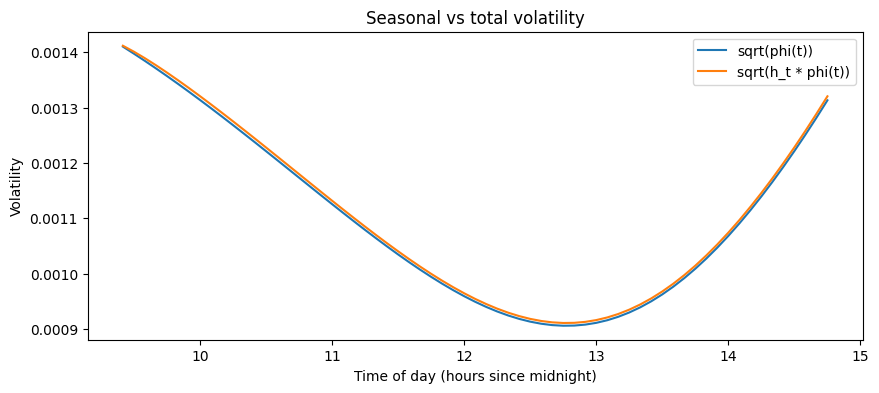

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
time_hours = df_day["SecondsPast"] / 3600.0
ax.plot(time_hours, sigma_seasonal, label="sqrt(phi(t))")
ax.plot(time_hours, sigma_total, label="sqrt(h_t * phi(t))")
ax.set_xlabel("Time of day (hours since midnight)")
ax.set_ylabel("Volatility")
ax.legend()
ax.set_title("Seasonal vs total volatility")
plt.show()